## Create Noise Masks

In [24]:
import numpy as np
import matplotlib.pyplot as plt

## Code to Generate Noise Masks

In [100]:
def rescale(array,to_255=False):
    #rescale between 0 and 1
    array = array - np.min(array)
    array = array / np.max(array)
    if(to_255):
        array = (array*255).astype(np.uint8)
    return(array)

def rad_symmetrize(full_mat, odd = True):
    '''Make a matrix 'radially odd symmetric' (discarding bottom half)
    Symmetry properties match that of phase spectrum of a real signal
    see: https://ccrma.stanford.edu/~jos/ReviewFourier/Symmetries_Real_Signals.html
    
    Parameters:
    full_mat (2d array):  Matrix we will upper triangular portion of to make resutling herm sym matrix.
    odd (bool): Is bottom of matrix negaive of top? (Set this to True for phase spectra, and false for amplitude spectra)
    
    Returns:
    herm_mat (2d array):  Matrix based on full_mat that is Hermetian Symmetric
    
    '''
    
    #check for even number of rows & pull of top row if needed
    if((full_mat.shape[0] % 2) == 0):
        add_bonus_row = True
        bonus_row, full_mat = np.vsplit(full_mat, [1,])
    else:
        add_bonus_row = False
    #check for even number of cols & pull off top col if needed
    if((full_mat.shape[1] % 2) == 0):
        add_bonus_col = True
        bonus_col, full_mat = np.hsplit(full_mat, [1,])
    else:
        add_bonus_col = False
    
    mat_top = full_mat[:np.shape(full_mat)[0]//2]
    #make bottom hermmetian symmetric wrt top
    mat_bottom  = np.flipud(np.fliplr(mat_top))
    if(odd):
        mat_bottom = -1 * mat_bottom

    #make mat middle horizontally symmetric
    mat_middle = full_mat[np.shape(full_mat)[0]//2]
    mm = mat_middle[:np.shape(mat_middle)[0]//2][::-1]
    if(odd):
        mm = -1*mm
    mat_middle[np.shape(mat_middle)[0]//2+1 :] = mm
    #remove DC component
    mat_middle [np.shape(mat_middle)[0]//2] = 0
    
    #put our matrix back together
    new_mat = np.vstack((mat_top, mat_middle, mat_bottom))
    
    #add back our extra columns and rows if needed
    if(add_bonus_col):
        new_mat = np.hstack((bonus_col,new_mat))
    if(add_bonus_row):
        new_mat = np.vstack((bonus_row,new_mat))
    
    return(new_mat)

def make_onef_amp(shape, alpha=1, beta=1.2):
    #make an amplitude spectrum of 1/f
    y, x = np.indices(shape)
    center = (shape[0]//2,shape[1]//2)
    print(center)
    r = np.hypot(x - center[1], y - center[0])
    amp = np.divide(beta,(1+r**alpha))
    # ensure aplitude spectrum is symmetric.
    amp = rad_symmetrize(amp, odd=False)
    return amp

def make_onef_ims(shape, alpha=1, beta=1.2, outputuint8=True, output3d=False):
    if(len(shape)==3):
        flag_3d = True
        shape = (shape[0],shape[1]) #remove color dim
    else:
        flag_3d=False
    #make an image with 1/f amplitude and uniformly random phase
    amp_onef = make_onef_amp(shape, alpha, beta) #get amplitude spectrum
    random_phase = np.random.rand(*shape)*2*np.pi - np.pi #get uniformly random phase dist [-pi,pi]
    recon_onef_rand = np.fft.ifft2(np.fft.ifftshift(amp_onef*np.exp(1j*random_phase))) #inverse fft to get image 
    recon_onef_rand = np.real(recon_onef_rand) #real part of image so we can plot and analyze it.
    recon_onef_rand = rescale(recon_onef_rand,to_255=outputuint8) #rescale to 0,1
    #recon_onef_rand = recon_onef_rand - np.mean(recon_onef_rand)
    #put back 3rd dim
    if(flag_3d and output3d):
        recon_onef_rand = np.repeat(recon_onef_rand[...,None],3,-1)
    return(recon_onef_rand)

(240, 320)


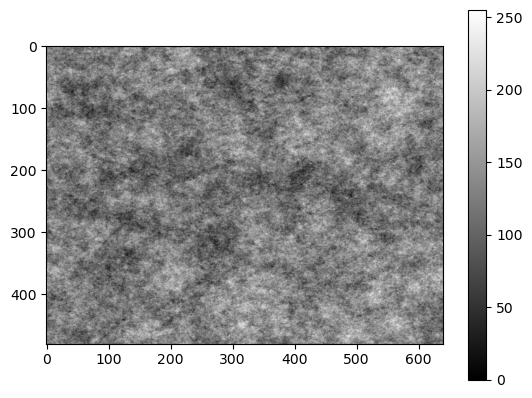

In [101]:
im = np.ones((480,640,3))
onefim = make_onef_ims(np.shape(im))
plt.imshow(onefim,cmap='gray')
plt.colorbar()

## Generate Masks for Each Image (to match size)

In [102]:
import glob
import cv2
imfolder = '/home/gridsan/vdutell/RosenholtzLab_shared/cocop_stims'
imlist = glob.glob(f'{imfolder}/*.jpg', recursive=False)
len(imlist)

47

In [105]:
for impath in imlist:
    im = cv2.imread(impath)
    imnum = impath.split('/')[-1].replace('.jpg','')
    noisemask = make_onef_ims(im.shape)
    savepath = f'/home/gridsan/groups/RosenholtzLab/cocop_stims/noise_masks/{imnum}_noisemask.png'
    cv2.imwrite(savepath,noisemask)
    #print(noisemask.shape)
    #plt.imshow(noisemask)
    #plt.title(imnum)
    #plt.show()

(213, 320)
(242, 320)
(240, 320)
(240, 320)
(213, 320)
(213, 320)
(212, 320)
(215, 320)
(239, 320)
(240, 320)
(203, 320)
(188, 250)
(240, 320)
(180, 320)
(213, 320)
(213, 320)
(213, 320)
(198, 320)
(213, 320)
(213, 320)
(213, 320)
(213, 320)
(271, 320)
(240, 320)
(213, 320)
(240, 320)
(212, 320)
(240, 320)
(199, 320)
(214, 320)
(212, 320)
(226, 320)
(240, 320)
(240, 320)
(168, 320)
(240, 320)
(214, 320)
(222, 320)
(240, 320)
(240, 320)
(213, 320)
(240, 320)
(214, 320)
(190, 250)
(214, 320)
(214, 320)
(187, 250)


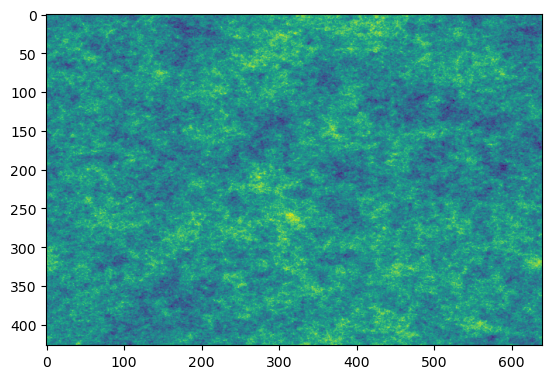

In [104]:
plt.imshow(noisemask)